In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 890.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=fb4a8c05f6d3bea3d5595d0f994195f74519cf3cb2e0057dc2f4a33656fde414
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=e7768f9926209464bdbdd21d7a4299759d26a6c880e328e45f055d63e144810b
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import torch
import tracemalloc
import torch.nn as nn
import math
#from torchtnt.utils.flops import FlopTensorDispatchMode
from fvcore.nn import FlopCountAnalysis
import copy
import time
class selfAttention(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(selfAttention, self).__init__()
        self.Wq = nn.Linear(in_dim, out_dim)
        self.Wk = nn.Linear(in_dim, out_dim)
        self.Wv = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        dims = q.shape[-1]
        qkT = nn.functional.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(dims), dim=-1)
        #qkT = nn.functional.softmax(qkT, dim=-1)
        attn = torch.matmul(qkT, v)
        return attn


if __name__ == "__main__":
    lengths = [10, 100, 1000, 10000, 50000]
    hidden_dim_size = 10
    self_attention = selfAttention(hidden_dim_size, hidden_dim_size).half().to("cuda")
    output_save = {}
    for i in range(len(lengths)):
        time_list = []
        for j in range(10):
            input_tensor = torch.randn(lengths[i], hidden_dim_size).half().to("cuda")
            memory_before = torch.cuda.memory_allocated()
            curtime = time.time()
            out = self_attention(input_tensor)
            memory_after = torch.cuda.memory_allocated()
            max_memory = torch.cuda.max_memory_allocated()
            memory_used = memory_after - memory_before
            flops = FlopCountAnalysis(self_attention, input_tensor)
            endtime = time.time()
            used_time = endtime - curtime
            time_list.append(used_time)
        output_save[lengths[i]] = time_list



        # print(f"FLOPs: {flops.total()}")
        # print(f"Memory used: {memory_used / 1024:.2f} KB")
        # print(f"Peak memory: {max_memory / 1024:.2f} KB")




In [ ]:
output_save

{10: [0.0011682510375976562,
  0.0007600784301757812,
  0.0006880760192871094,
  0.0006387233734130859,
  0.0006704330444335938,
  0.0006594657897949219,
  0.0006392002105712891,
  0.0006315708160400391,
  0.0006473064422607422,
  0.0006606578826904297],
 100: [0.0007588863372802734,
  0.0008957386016845703,
  0.0006463527679443359,
  0.0006442070007324219,
  0.0006468296051025391,
  0.0006477832794189453,
  0.0006756782531738281,
  0.0006806850433349609,
  0.0006384849548339844,
  0.0006546974182128906],
 1000: [0.0006818771362304688,
  0.0006613731384277344,
  0.0006539821624755859,
  0.0006546974182128906,
  0.0006756782531738281,
  0.0006399154663085938,
  0.0006427764892578125,
  0.0006761550903320312,
  0.0006577968597412109,
  0.0006504058837890625],
 10000: [0.0006566047668457031,
  0.0006444454193115234,
  0.0010232925415039062,
  0.0006365776062011719,
  0.0006780624389648438,
  0.0006320476531982422,
  0.0006535053253173828,
  0.0006339550018310547,
  0.0006711483001708984,


In [ ]:
import torch
import torch.nn as nn
import math
from fvcore.nn import FlopCountAnalysis
import json
import timeit

class selfAttention(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(selfAttention, self).__init__()
        self.Wq = nn.Linear(in_dim, out_dim)
        self.Wk = nn.Linear(in_dim, out_dim)
        self.Wv = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        dims = q.shape[-1]
        qkT = nn.functional.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(dims), dim=-1)
        attn = torch.matmul(qkT, v)
        return attn

def run_self_attention(self_attention, input_tensor):
    return self_attention(input_tensor)

if __name__ == "__main__":
    lengths = [10, 100, 1000, 10000, 50000]
    hidden_dim_size = 10
    self_attention = selfAttention(hidden_dim_size, hidden_dim_size).half().to("cuda")
    output_save = {}

    for i in range(len(lengths)):
        input_tensor = torch.randn(lengths[i], hidden_dim_size).half().to("cuda")
        memory_before = torch.cuda.memory_allocated()

        # Time the execution
        number_of_runs = 100
        execution_time = timeit.timeit(lambda: run_self_attention(self_attention, input_tensor), number=number_of_runs)
        average_time = execution_time / number_of_runs

        memory_after = torch.cuda.memory_allocated()
        max_memory = torch.cuda.max_memory_allocated()
        memory_used = memory_after - memory_before
        flops = FlopCountAnalysis(self_attention, input_tensor)
        output_save[lengths[i]] = {
            "flops": flops.total(),
            "memory_used_mb": f"{memory_used / 1024**2:.2f}",
            "max_memory_mb": f"{max_memory / 1024**2:.2f}",
            "average_execution_time_ms": f"{average_time * 1000:.4f}"
        }

    # Save results to a JSON file
    with open('self_attention_benchmark.json', 'w') as f:
        json.dump(output_save, f, indent=4)

    # Print results to console
    print("Results saved to self_attention_benchmark.json")
    print("Summary:")
    for length, data in output_save.items():
        print(f"Length {length}:")
        print(f"  FLOPs: {data['flops']}")
        print(f"  Memory Used: {data['memory_used_mb']} MB")
        print(f"  Max Memory: {data['max_memory_mb']} MB")
        print(f"  Average Execution Time: {data['average_execution_time_ms']} ms")

Results saved to self_attention_benchmark.json
Summary:
Length 10:
  FLOPs: 5000
  Memory Used: 0.00 MB
  Max Memory: 24054.59 MB
  Average Execution Time: 0.2015 ms
Length 100:
  FLOPs: 230000
  Memory Used: 0.00 MB
  Max Memory: 24054.59 MB
  Average Execution Time: 0.1952 ms
Length 1000:
  FLOPs: 20300000
  Memory Used: 0.00 MB
  Max Memory: 24054.59 MB
  Average Execution Time: 0.2071 ms
Length 10000:
  FLOPs: 2003000000
  Memory Used: 0.00 MB
  Max Memory: 24054.59 MB
  Average Execution Time: 0.2054 ms
Length 50000:
  FLOPs: 50015000000
  Memory Used: 0.00 MB
  Max Memory: 24054.59 MB
  Average Execution Time: 0.2607 ms


In [ ]:
length = [10, 100, 1000, 10000, 50000]
flops = [5000, 230000, 20300000, 2003000000, 50015000000]

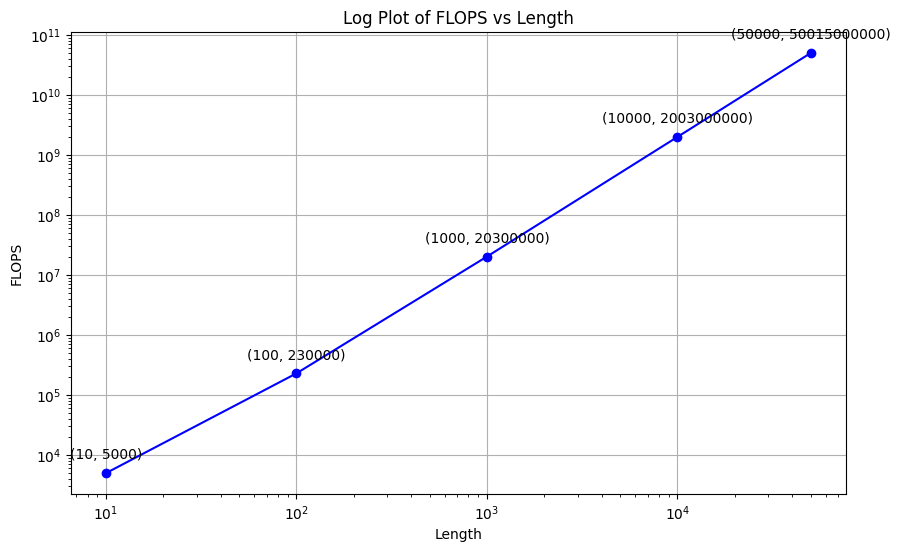

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

length = [10, 100, 1000, 10000, 50000]
flops = [5000, 230000, 20300000, 2003000000, 50015000000]

plt.figure(figsize=(10, 6))
plt.loglog(length, flops, 'bo-')  # 'bo-' means blue color, circle markers, solid line
plt.xlabel('Length')
plt.ylabel('FLOPS')
plt.title('FLOPS vs Length')
plt.grid(True)

# Add annotations for each point
for i, (x, y) in enumerate(zip(length, flops)):
    plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

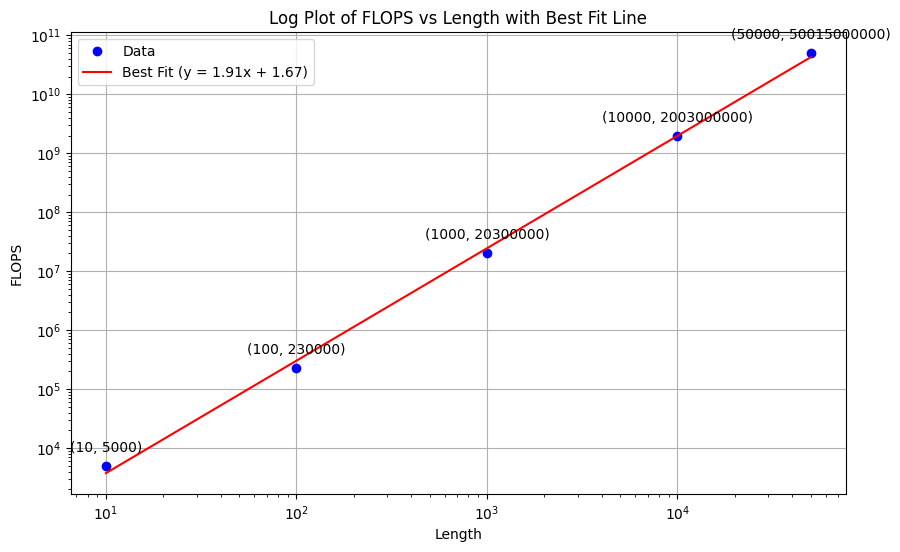

Equation of the line: log(y) = 1.91 * log(x) + 1.67
Or equivalently: y = 4.66e+01 * x^1.91


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

length = [10, 100, 1000, 10000, 50000]
flops = [5000, 230000, 20300000, 2003000000, 50015000000]

# Convert to logarithmic scale
log_length = np.log10(length)
log_flops = np.log10(flops)

# Calculate the line of best fit
coeffs = np.polyfit(log_length, log_flops, 1)
poly = np.poly1d(coeffs)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.loglog(length, flops, 'bo', label='Data')  # 'bo' means blue color, circle markers

# Plot the line of best fit
x_range = np.logspace(np.log10(min(length)), np.log10(max(length)), 100)
plt.loglog(x_range, 10**poly(np.log10(x_range)), 'r-', label=f'Best Fit (y = {coeffs[0]:.2f}x + {coeffs[1]:.2f})')

plt.xlabel('Length')
plt.ylabel('FLOPS')
plt.title('Length vs FLOPS')
plt.grid(True)
plt.legend()

# Add annotations for each point
for i, (x, y) in enumerate(zip(length, flops)):
    plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Print the equation of the line
print(f"Equation of the line: log(y) = {coeffs[0]:.2f} * log(x) + {coeffs[1]:.2f}")
print(f"Or equivalently: y = {10**coeffs[1]:.2e} * x^{coeffs[0]:.2f}")

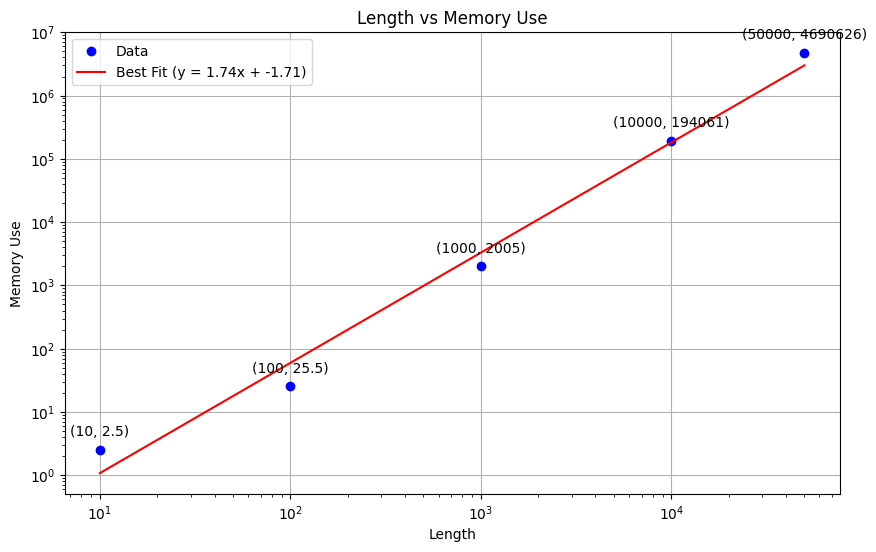

Equation of the line: log(y) = 1.74 * log(x) + -1.71
Or equivalently: y = 1.96e-02 * x^1.74


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

length = [10, 100, 1000, 10000, 50000]
memory_use = [2.5, 25.5, 2005, 194061, 4690626]

# Convert to logarithmic scale
log_length = np.log10(length)
log_memory_use = np.log10(memory_use)

# Calculate the line of best fit
coeffs = np.polyfit(log_length, log_memory_use, 1)
poly = np.poly1d(coeffs)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.loglog(length, flops, 'bo', label='Data')  # 'bo' means blue color, circle markers

# Plot the line of best fit
x_range = np.logspace(np.log10(min(length)), np.log10(max(length)), 100)
plt.loglog(x_range, 10**poly(np.log10(x_range)), 'r-', label=f'Best Fit (y = {coeffs[0]:.2f}x + {coeffs[1]:.2f})')

plt.xlabel('Length')
plt.ylabel('Memory Use')
plt.title('Length vs Memory Use')
plt.grid(True)
plt.legend()

# Add annotations for each point
for i, (x, y) in enumerate(zip(length, flops)):
    plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Print the equation of the line
print(f"Equation of the line: log(y) = {coeffs[0]:.2f} * log(x) + {coeffs[1]:.2f}")
print(f"Or equivalently: y = {10**coeffs[1]:.2e} * x^{coeffs[0]:.2f}")

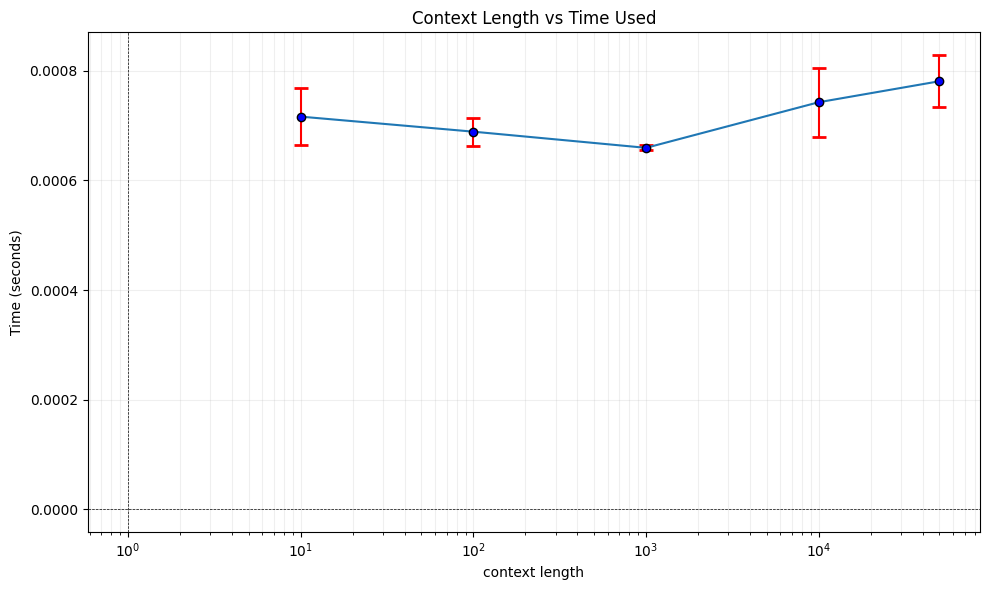

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    10: [0.0011682510375976562, 0.0007600784301757812, 0.0006880760192871094, 0.0006387233734130859, 0.0006704330444335938, 0.0006594657897949219, 0.0006392002105712891, 0.0006315708160400391, 0.0006473064422607422, 0.0006606578826904297],
    100: [0.0007588863372802734, 0.0008957386016845703, 0.0006463527679443359, 0.0006442070007324219, 0.0006468296051025391, 0.0006477832794189453, 0.0006756782531738281, 0.0006806850433349609, 0.0006384849548339844, 0.0006546974182128906],
    1000: [0.0006818771362304688, 0.0006613731384277344, 0.0006539821624755859, 0.0006546974182128906, 0.0006756782531738281, 0.0006399154663085938, 0.0006427764892578125, 0.0006761550903320312, 0.0006577968597412109, 0.0006504058837890625],
    10000: [0.0006566047668457031, 0.0006444454193115234, 0.0010232925415039062, 0.0006365776062011719, 0.0006780624389648438, 0.0006320476531982422, 0.0006535053253173828, 0.0006339550018310547, 0.0006711483001708984, 0.0011968612670898438],
    50000: [0.0006816387176513672, 0.0007975101470947266, 0.0007491111755371094, 0.0007960796356201172, 0.0007872581481933594, 0.000751495361328125, 0.0011878013610839844, 0.0007035732269287109, 0.0006799697875976562, 0.0006749629974365234]
}

# Calculate means and standard errors
x = list(data.keys())
y = [np.mean(values) for values in data.values()]
yerr = [np.std(values, ddof=1) / np.sqrt(len(values)) for values in data.values()]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, capthick=2, ecolor='red', markeredgecolor='black', markerfacecolor='blue')

# Customize the plot
plt.xscale('log')
plt.xlabel('context length')
plt.ylabel('Time (seconds)')
plt.title('Context Length vs Time Used')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add horizontal and vertical lines at y=0 and x=1
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='k', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import torch
import tracemalloc
import torch.nn as nn
import math
#from torchtnt.utils.flops import FlopTensorDispatchMode
from fvcore.nn import FlopCountAnalysis
import copy
import time
class selfAttention(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(selfAttention, self).__init__()
        self.Wq = nn.Linear(in_dim, out_dim)
        self.Wk = nn.Linear(in_dim, out_dim)
        self.Wv = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        dims = q.shape[-1]
        qkT = nn.functional.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(dims), dim=-1)
        #qkT = nn.functional.softmax(qkT, dim=-1)
        attn = torch.matmul(qkT, v)
        return attn


if __name__ == "__main__":
    lengths = [10, 100, 1000, 10000, 50000]
    hidden_dim_size = 10
    self_attention = selfAttention(hidden_dim_size, hidden_dim_size).half()
    output_save = {}
    for i in range(len(lengths)):
        # time_list = []
        # for j in range(10):
        input_tensor = torch.randn(lengths[i], hidden_dim_size).half()
        memory_before = torch.cuda.memory_allocated()
        curtime = time.time()
        out = self_attention(input_tensor)
        memory_after = torch.cuda.memory_allocated()
        max_memory = torch.cuda.max_memory_allocated()
        memory_used = memory_after - memory_before
        flops = FlopCountAnalysis(self_attention, input_tensor)
        endtime = time.time()
        used_time = endtime - curtime
        time_list.append(used_time)
        print(f"FLOPs: {flops.total()}")

        output_save[lengths[i]] = time_list








FLOPs: 5000
Memory used: 0.00 KB
Peak memory: 0.00 KB
FLOPs: 230000
Memory used: 0.00 KB
Peak memory: 0.00 KB
FLOPs: 20300000
Memory used: 0.00 KB
Peak memory: 0.00 KB


FLOPs: 2003000000
Memory used: 0.00 KB
Peak memory: 0.00 KB


FLOPs: 50015000000
Memory used: 0.00 KB
Peak memory: 0.00 KB


In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61398 sha256=ca0aca5658c2e88f6131c8475081dbbdf8a13e8a17e2ada89c5a7efb9a5e1dba
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=8156141fbbc0e879bde0f1a24c252181fb5b60b871bed010ed40584aef591a28
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import torch
import tracemalloc
import torch.nn as nn
import math
from fvcore.nn import FlopCountAnalysis
import time

class selfAttention(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(selfAttention, self).__init__()
        self.Wq = nn.Linear(in_dim, out_dim)
        self.Wk = nn.Linear(in_dim, out_dim)
        self.Wv = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)
        dims = q.shape[-1]
        qkT = nn.functional.softmax(torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(dims), dim=-1)
        attn = torch.matmul(qkT, v)
        return attn

if __name__ == "__main__":
    lengths = [10, 100, 1000, 10000, 50000]
    hidden_dim_size = 10
    self_attention = selfAttention(hidden_dim_size, hidden_dim_size)
    output_save = {}

    for i in range(len(lengths)):
        # time_list = []
        # for j in range(10):
        input_tensor = torch.randn(lengths[i], hidden_dim_size)

        # Start tracking memory
        tracemalloc.start()

        curtime = time.time()
        out = self_attention(input_tensor)

        # Get memory usage
        current, peak = tracemalloc.get_traced_memory()

        flops = FlopCountAnalysis(self_attention, input_tensor)
        endtime = time.time()
        used_time = endtime - curtime
        time_list.append(used_time)

        print(f"Input size: {lengths[i]}")
        print(f"Current memory usage: {current / 10**3:.2f} KB")
        print(f"Peak memory usage: {peak / 10**3:.2f} KB")
        print(f"Time taken: {used_time:.4f} seconds")
        print(f"FLOPs: {flops.total()}")
        print("--------------------")

        # Stop tracking memory
        tracemalloc.stop()




Input size: 10
Current memory usage: 1.11 KB
Peak memory usage: 1.29 KB
Time taken: 0.0009 seconds
FLOPs: 5000
--------------------
Input size: 100
Current memory usage: 0.63 KB
Peak memory usage: 0.81 KB
Time taken: 0.0007 seconds
FLOPs: 230000
--------------------
Input size: 1000
Current memory usage: 0.48 KB
Peak memory usage: 0.66 KB
Time taken: 0.0037 seconds
FLOPs: 20300000
--------------------
Input size: 10000
Current memory usage: 11.05 KB
Peak memory usage: 60.28 KB
Time taken: 1.0273 seconds


FLOPs: 2003000000
--------------------
Input size: 50000
Current memory usage: 9.56 KB
Peak memory usage: 79.61 KB
Time taken: 8.6073 seconds


FLOPs: 50015000000
--------------------


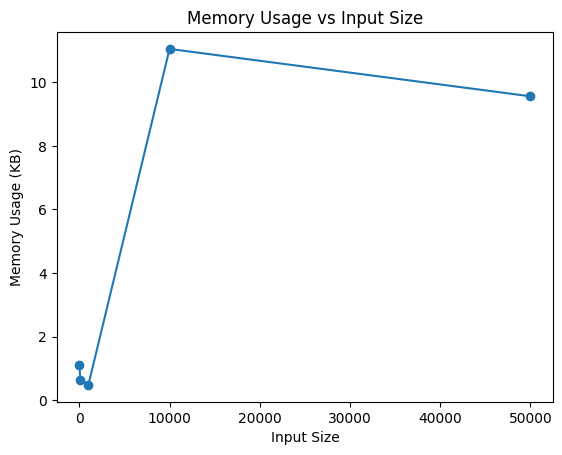

In [ ]:
input_size = [10, 100, 1000, 10000, 50000]
memory_usage = [1.11, .63, .48, 11.05, 9.56]

#plot
import matplotlib.pyplot as plt
plt.plot(input_size, memory_usage, marker='o')
plt.xlabel('Input Size')
plt.ylabel('Memory Usage (KB)')
plt.title('Memory Usage vs Input Size')
plt.show()

In [ ]:
output_save


{10: [0.0007064342498779297,
  0.002276897430419922,
  0.0006289482116699219,
  0.0005970001220703125,
  0.0005655288696289062,
  0.0017852783203125,
  0.0005345344543457031,
  0.0005908012390136719,
  0.0005555152893066406,
  0.0006012916564941406],
 100: [0.0005812644958496094,
  0.0006937980651855469,
  0.0005671977996826172,
  0.0027494430541992188,
  0.0028378963470458984,
  0.0006549358367919922,
  0.0005466938018798828,
  0.0006771087646484375,
  0.0006582736968994141,
  0.0006363391876220703],
 1000: [0.003330230712890625,
  0.0046939849853515625,
  0.0025167465209960938,
  0.0024633407592773438,
  0.0024042129516601562,
  0.0027854442596435547,
  0.005721330642700195,
  0.00244903564453125,
  0.0025207996368408203,
  0.0023927688598632812],
 10000: [0.3845705986022949,
  0.44527316093444824,
  0.42743587493896484,
  0.3426051139831543,
  0.34475207328796387,
  0.33964061737060547,
  0.32824087142944336,
  0.33124542236328125,
  0.3365936279296875,
  0.32598233222961426],
 5000

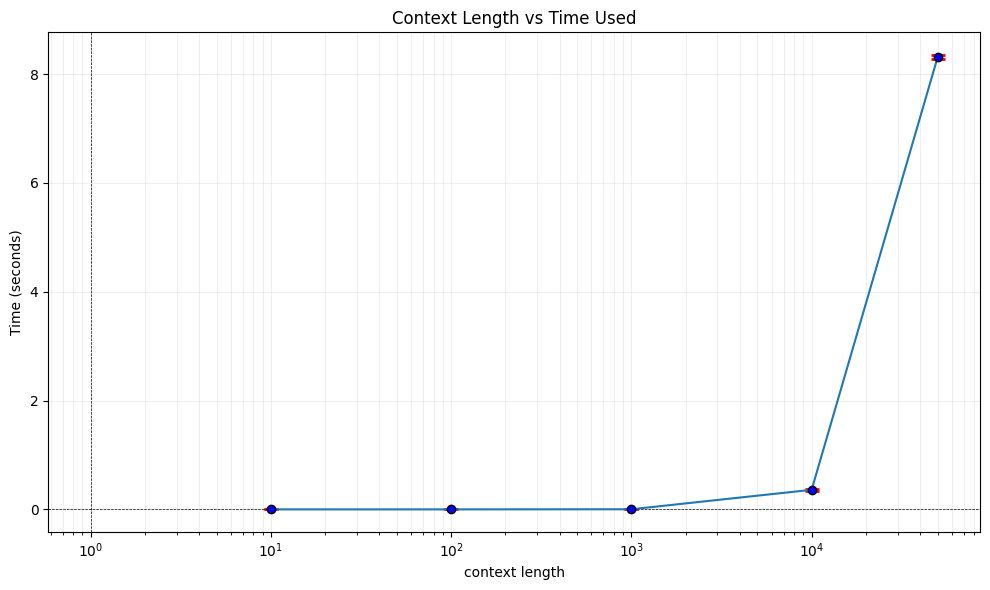

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = output_save

# Calculate means and standard errors
x = list(data.keys())
y = [np.mean(values) for values in data.values()]
yerr = [np.std(values, ddof=1) / np.sqrt(len(values)) for values in data.values()]

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, capthick=2, ecolor='red', markeredgecolor='black', markerfacecolor='blue')

# Customize the plot
plt.xscale('log')
plt.xlabel('context length')
plt.ylabel('Time (seconds)')
plt.title('Context Length vs Time Used')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add horizontal and vertical lines at y=0 and x=1
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='k', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()